## Dependencies

In [43]:
# installing dependencies
# !pip install tensorflow==2.9.0 tensorflow-gpu==2.9.0 opencv-python mediapipe sklearn matplotlib

In [1]:
# importing all required libraries

import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

## Keypoints using MP Holistic

In [2]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [4]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [5]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=3), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [7]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        # qprint(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
cap.release()
cv2.destroyAllWindows()

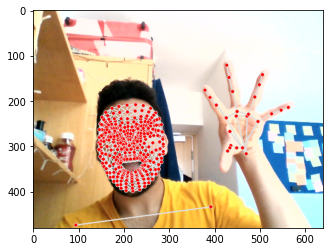

In [8]:
draw_landmarks(frame, results)
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

## Extract Keypoint Values

In [9]:
len(results.left_hand_landmarks.landmark)

21

In [10]:
pose = []
for res in results.pose_landmarks.landmark:
    test = np.array([res.x, res.y, res.z, res.visibility])
    pose.append(test)

In [11]:
pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

In [12]:
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)


In [13]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [14]:
result_test = extract_keypoints(results)

In [15]:
print(len(result_test))
468*3+33*4+21*3+21*3

1662


1662

In [16]:
np.save('0', result_test)

In [17]:
np.load('0.npy')

array([ 0.33276603,  0.62284535, -0.77667892, ...,  0.        ,
        0.        ,  0.        ])

## Setup Folders for Collection

In [17]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data') 

# Actions that we try to detect
actions = np.array(['A', 'B', 'C'])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

In [18]:
# Folder structure
# A
## 0
## 1
## 2
## ...
## 29
# B

# C

In [19]:
for action in actions: 
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

## Collect Keypoint Values from webcam to train and test

In [20]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)
#                 print(results)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(2000)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

In [21]:
cap.release()
cv2.destroyAllWindows()

## Preprocess Data and Create Labels and Features

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [ ]:
label_map = {label:num for num, label in enumerate(actions)}
label_map

In [24]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [66]:
np.array(sequences).shape

(90, 30, 1662)

Here we have 90 videos, 30 frames each and 1662 key points

In [25]:
np.array(labels).shape

(90,)

In [26]:
X = np.array(sequences)

In [27]:
X.shape

(90, 30, 1662)

In [28]:
y = to_categorical(labels).astype(int)

In [29]:
y

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0,

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [31]:
y_test.shape

(5, 3)

## Build and Train LSTM Neural Network

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [48]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [61]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

* The requirements to use the cuDNN implementation are:<br>

activation == tanh    <br>
recurrent_activation == sigmoid    <br>
recurrent_dropout == 0    <br>
unroll is False    <br>
use_bias is True    <br>
Inputs, if use masking, are strictly right-padded.    <br>
Eager execution is enabled in the outermost context.    <br>

In [50]:
res = [.7, 0.2, 0.1]

In [51]:
actions[np.argmax(res)]

'A'

In [62]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [53]:
model.fit(X_train, y_train, epochs=2000, callbacks=[tb_callback])

Epoch 1/2000
3/3 [==============================] - 5s 184ms/step - loss: 16.1139 - categorical_accuracy: 0.2824
Epoch 2/2000
3/3 [==============================] - 1s 190ms/step - loss: 44.3747 - categorical_accuracy: 0.2941
Epoch 3/2000
3/3 [==============================] - 1s 170ms/step - loss: 22.2070 - categorical_accuracy: 0.4588
Epoch 4/2000
3/3 [==============================] - 1s 220ms/step - loss: 14.7345 - categorical_accuracy: 0.3294
Epoch 5/2000
3/3 [==============================] - 1s 180ms/step - loss: 12.7567 - categorical_accuracy: 0.4118
Epoch 6/2000
3/3 [==============================] - 1s 172ms/step - loss: 13.9984 - categorical_accuracy: 0.2588
Epoch 7/2000
3/3 [==============================] - 0s 167ms/step - loss: 16.3795 - categorical_accuracy: 0.2471
Epoch 8/2000
3/3 [==============================] - 1s 186ms/step - loss: 32.3490 - categorical_accuracy: 0.3529
Epoch 9/2000
3/3 [==============================] - 1s 227ms/step - loss: 24.9792 - categorical_

3/3 [==============================] - 1s 217ms/step - loss: 63.7275 - categorical_accuracy: 0.5529
Epoch 73/2000
3/3 [==============================] - 0s 160ms/step - loss: 73.5595 - categorical_accuracy: 0.2941
Epoch 74/2000
3/3 [==============================] - 1s 163ms/step - loss: 51.9048 - categorical_accuracy: 0.3294
Epoch 75/2000
3/3 [==============================] - 0s 161ms/step - loss: 52.9437 - categorical_accuracy: 0.3765
Epoch 76/2000
3/3 [==============================] - 0s 156ms/step - loss: 37.5980 - categorical_accuracy: 0.2941
Epoch 77/2000
3/3 [==============================] - 1s 207ms/step - loss: 33.6703 - categorical_accuracy: 0.3529
Epoch 78/2000
3/3 [==============================] - 0s 176ms/step - loss: 29.8888 - categorical_accuracy: 0.4235
Epoch 79/2000
3/3 [==============================] - 1s 201ms/step - loss: 36.8264 - categorical_accuracy: 0.2941
Epoch 80/2000
3/3 [==============================] - 0s 168ms/step - loss: 15.7670 - categorical_accur

3/3 [==============================] - 1s 181ms/step - loss: 7.8227 - categorical_accuracy: 0.4118
Epoch 145/2000
3/3 [==============================] - 1s 202ms/step - loss: 7.7754 - categorical_accuracy: 0.3765
Epoch 146/2000
3/3 [==============================] - 1s 168ms/step - loss: 7.7678 - categorical_accuracy: 0.2824
Epoch 147/2000
3/3 [==============================] - 0s 158ms/step - loss: 6.6407 - categorical_accuracy: 0.4706
Epoch 148/2000
3/3 [==============================] - 0s 171ms/step - loss: 6.4750 - categorical_accuracy: 0.4118
Epoch 149/2000
3/3 [==============================] - 0s 181ms/step - loss: 4.6517 - categorical_accuracy: 0.2941
Epoch 150/2000
3/3 [==============================] - 1s 234ms/step - loss: 5.1868 - categorical_accuracy: 0.3647
Epoch 151/2000
3/3 [==============================] - 1s 146ms/step - loss: 6.3629 - categorical_accuracy: 0.4118
Epoch 152/2000
3/3 [==============================] - 1s 225ms/step - loss: 8.9647 - categorical_accura

Epoch 216/2000
3/3 [==============================] - 1s 219ms/step - loss: 1.1112 - categorical_accuracy: 0.5176
Epoch 217/2000
3/3 [==============================] - 1s 268ms/step - loss: 1.6214 - categorical_accuracy: 0.3647
Epoch 218/2000
3/3 [==============================] - 1s 170ms/step - loss: 1.3169 - categorical_accuracy: 0.4235
Epoch 219/2000
3/3 [==============================] - 1s 193ms/step - loss: 1.8719 - categorical_accuracy: 0.3529
Epoch 220/2000
3/3 [==============================] - 2s 761ms/step - loss: 1.9286 - categorical_accuracy: 0.3765
Epoch 221/2000
3/3 [==============================] - 1s 186ms/step - loss: 1.0998 - categorical_accuracy: 0.4706
Epoch 222/2000
3/3 [==============================] - 0s 172ms/step - loss: 1.6820 - categorical_accuracy: 0.3882
Epoch 223/2000
3/3 [==============================] - 0s 169ms/step - loss: 1.9134 - categorical_accuracy: 0.3647
Epoch 224/2000
3/3 [==============================] - 1s 249ms/step - loss: 1.5743 - cat

3/3 [==============================] - 1s 189ms/step - loss: 1.9451 - categorical_accuracy: 0.4706
Epoch 288/2000
3/3 [==============================] - 1s 198ms/step - loss: 2.1468 - categorical_accuracy: 0.4471
Epoch 289/2000
3/3 [==============================] - 1s 255ms/step - loss: 1.5593 - categorical_accuracy: 0.4706
Epoch 290/2000
3/3 [==============================] - 1s 212ms/step - loss: 1.0786 - categorical_accuracy: 0.4471
Epoch 291/2000
3/3 [==============================] - 1s 174ms/step - loss: 1.6125 - categorical_accuracy: 0.4118
Epoch 292/2000
3/3 [==============================] - 1s 168ms/step - loss: 1.5453 - categorical_accuracy: 0.4000
Epoch 293/2000
3/3 [==============================] - 1s 205ms/step - loss: 1.9336 - categorical_accuracy: 0.4353
Epoch 294/2000
3/3 [==============================] - 1s 231ms/step - loss: 1.3604 - categorical_accuracy: 0.3765
Epoch 295/2000
3/3 [==============================] - 1s 195ms/step - loss: 1.2722 - categorical_accura

Epoch 359/2000
3/3 [==============================] - 1s 164ms/step - loss: 1.0112 - categorical_accuracy: 0.5529
Epoch 360/2000
3/3 [==============================] - 0s 169ms/step - loss: 0.9387 - categorical_accuracy: 0.5647
Epoch 361/2000
3/3 [==============================] - 1s 184ms/step - loss: 1.0526 - categorical_accuracy: 0.5529
Epoch 362/2000
3/3 [==============================] - 1s 193ms/step - loss: 1.0974 - categorical_accuracy: 0.5882
Epoch 363/2000
3/3 [==============================] - 1s 206ms/step - loss: 1.3361 - categorical_accuracy: 0.5294
Epoch 364/2000
3/3 [==============================] - 0s 163ms/step - loss: 1.3429 - categorical_accuracy: 0.5412
Epoch 365/2000
3/3 [==============================] - 1s 206ms/step - loss: 1.3363 - categorical_accuracy: 0.5176
Epoch 366/2000
3/3 [==============================] - 1s 204ms/step - loss: 1.0343 - categorical_accuracy: 0.6118
Epoch 367/2000
3/3 [==============================] - 1s 219ms/step - loss: 1.0841 - cat

3/3 [==============================] - 1s 274ms/step - loss: 1.3759 - categorical_accuracy: 0.4706
Epoch 431/2000
3/3 [==============================] - 1s 269ms/step - loss: 1.3238 - categorical_accuracy: 0.5294
Epoch 432/2000
3/3 [==============================] - 1s 293ms/step - loss: 1.7484 - categorical_accuracy: 0.4941
Epoch 433/2000
3/3 [==============================] - 1s 278ms/step - loss: 2.3134 - categorical_accuracy: 0.4941
Epoch 434/2000
3/3 [==============================] - 1s 262ms/step - loss: 1.9671 - categorical_accuracy: 0.5529
Epoch 435/2000
3/3 [==============================] - 1s 297ms/step - loss: 2.9303 - categorical_accuracy: 0.3647
Epoch 436/2000
3/3 [==============================] - 1s 308ms/step - loss: 2.3572 - categorical_accuracy: 0.4000
Epoch 437/2000
3/3 [==============================] - 1s 255ms/step - loss: 1.1604 - categorical_accuracy: 0.4941
Epoch 438/2000
3/3 [==============================] - 1s 233ms/step - loss: 1.0644 - categorical_accura

Epoch 502/2000
3/3 [==============================] - 1s 192ms/step - loss: 1.5528 - categorical_accuracy: 0.4588
Epoch 503/2000
3/3 [==============================] - 1s 213ms/step - loss: 1.4488 - categorical_accuracy: 0.4706
Epoch 504/2000
3/3 [==============================] - 1s 190ms/step - loss: 1.6348 - categorical_accuracy: 0.4588
Epoch 505/2000
3/3 [==============================] - 1s 185ms/step - loss: 1.2550 - categorical_accuracy: 0.5294
Epoch 506/2000
3/3 [==============================] - 1s 187ms/step - loss: 1.1700 - categorical_accuracy: 0.4588
Epoch 507/2000
3/3 [==============================] - 1s 180ms/step - loss: 1.3855 - categorical_accuracy: 0.5059
Epoch 508/2000
3/3 [==============================] - 1s 177ms/step - loss: 1.5207 - categorical_accuracy: 0.3529
Epoch 509/2000
3/3 [==============================] - 1s 169ms/step - loss: 1.3798 - categorical_accuracy: 0.5059
Epoch 510/2000
3/3 [==============================] - 1s 181ms/step - loss: 1.6554 - cat

3/3 [==============================] - 1s 259ms/step - loss: 0.9733 - categorical_accuracy: 0.4941
Epoch 574/2000
3/3 [==============================] - 1s 406ms/step - loss: 0.9040 - categorical_accuracy: 0.5529
Epoch 575/2000
3/3 [==============================] - 1s 344ms/step - loss: 1.0954 - categorical_accuracy: 0.5529
Epoch 576/2000
3/3 [==============================] - 1s 562ms/step - loss: 1.0589 - categorical_accuracy: 0.5294
Epoch 577/2000
3/3 [==============================] - 1s 289ms/step - loss: 1.3987 - categorical_accuracy: 0.4941
Epoch 578/2000
3/3 [==============================] - 1s 234ms/step - loss: 1.1920 - categorical_accuracy: 0.4471
Epoch 579/2000
3/3 [==============================] - 1s 227ms/step - loss: 1.1868 - categorical_accuracy: 0.4824
Epoch 580/2000
3/3 [==============================] - 1s 251ms/step - loss: 1.1375 - categorical_accuracy: 0.4824
Epoch 581/2000
3/3 [==============================] - 1s 298ms/step - loss: 1.2612 - categorical_accura

Epoch 645/2000
3/3 [==============================] - 1s 193ms/step - loss: 1.1174 - categorical_accuracy: 0.4941
Epoch 646/2000
3/3 [==============================] - 1s 175ms/step - loss: 0.8658 - categorical_accuracy: 0.5647
Epoch 647/2000
3/3 [==============================] - 1s 200ms/step - loss: 0.9902 - categorical_accuracy: 0.5529
Epoch 648/2000
3/3 [==============================] - 1s 225ms/step - loss: 1.0931 - categorical_accuracy: 0.4941
Epoch 649/2000
3/3 [==============================] - 1s 220ms/step - loss: 1.1126 - categorical_accuracy: 0.5647
Epoch 650/2000
3/3 [==============================] - 1s 256ms/step - loss: 0.9166 - categorical_accuracy: 0.5294
Epoch 651/2000
3/3 [==============================] - 0s 173ms/step - loss: 1.1773 - categorical_accuracy: 0.5294
Epoch 652/2000
3/3 [==============================] - 1s 218ms/step - loss: 0.7998 - categorical_accuracy: 0.5765
Epoch 653/2000
3/3 [==============================] - 1s 222ms/step - loss: 0.8504 - cat

3/3 [==============================] - 1s 249ms/step - loss: 1.0310 - categorical_accuracy: 0.5529
Epoch 717/2000
3/3 [==============================] - 1s 267ms/step - loss: 1.1449 - categorical_accuracy: 0.5294
Epoch 718/2000
3/3 [==============================] - 1s 345ms/step - loss: 1.2610 - categorical_accuracy: 0.5765
Epoch 719/2000
3/3 [==============================] - 1s 282ms/step - loss: 0.9287 - categorical_accuracy: 0.5765
Epoch 720/2000
3/3 [==============================] - 1s 274ms/step - loss: 1.2961 - categorical_accuracy: 0.5176
Epoch 721/2000
3/3 [==============================] - 1s 272ms/step - loss: 1.3883 - categorical_accuracy: 0.4471
Epoch 722/2000
3/3 [==============================] - 1s 285ms/step - loss: 1.1529 - categorical_accuracy: 0.5294
Epoch 723/2000
3/3 [==============================] - 1s 287ms/step - loss: 1.1754 - categorical_accuracy: 0.5412
Epoch 724/2000
3/3 [==============================] - 1s 265ms/step - loss: 1.3075 - categorical_accura

Epoch 788/2000
3/3 [==============================] - 1s 247ms/step - loss: 1.8458 - categorical_accuracy: 0.4118
Epoch 789/2000
3/3 [==============================] - 1s 298ms/step - loss: 1.1601 - categorical_accuracy: 0.5765
Epoch 790/2000
3/3 [==============================] - 1s 272ms/step - loss: 0.9334 - categorical_accuracy: 0.5176
Epoch 791/2000
3/3 [==============================] - 1s 249ms/step - loss: 1.0548 - categorical_accuracy: 0.5176
Epoch 792/2000
3/3 [==============================] - 1s 279ms/step - loss: 0.9775 - categorical_accuracy: 0.4941
Epoch 793/2000
3/3 [==============================] - 1s 297ms/step - loss: 0.8271 - categorical_accuracy: 0.5765
Epoch 794/2000
3/3 [==============================] - 1s 251ms/step - loss: 1.0490 - categorical_accuracy: 0.5294
Epoch 795/2000
3/3 [==============================] - 1s 314ms/step - loss: 1.0501 - categorical_accuracy: 0.5882
Epoch 796/2000
3/3 [==============================] - 1s 289ms/step - loss: 1.0651 - cat

3/3 [==============================] - 1s 300ms/step - loss: 1.0045 - categorical_accuracy: 0.5412
Epoch 860/2000
3/3 [==============================] - 1s 266ms/step - loss: 0.8701 - categorical_accuracy: 0.5765
Epoch 861/2000
3/3 [==============================] - 1s 259ms/step - loss: 0.9743 - categorical_accuracy: 0.5765
Epoch 862/2000
3/3 [==============================] - 1s 300ms/step - loss: 1.9394 - categorical_accuracy: 0.4235
Epoch 863/2000
3/3 [==============================] - 1s 280ms/step - loss: 1.2172 - categorical_accuracy: 0.5059
Epoch 864/2000
3/3 [==============================] - 1s 295ms/step - loss: 1.1123 - categorical_accuracy: 0.4000
Epoch 865/2000
3/3 [==============================] - 1s 267ms/step - loss: 1.1129 - categorical_accuracy: 0.5529
Epoch 866/2000
3/3 [==============================] - 1s 252ms/step - loss: 1.3859 - categorical_accuracy: 0.4118
Epoch 867/2000
3/3 [==============================] - 1s 221ms/step - loss: 1.4751 - categorical_accura

Epoch 931/2000
3/3 [==============================] - 1s 180ms/step - loss: 5.2098 - categorical_accuracy: 0.2353
Epoch 932/2000
3/3 [==============================] - 1s 206ms/step - loss: 5.1103 - categorical_accuracy: 0.4235
Epoch 933/2000
3/3 [==============================] - 1s 189ms/step - loss: 6.3327 - categorical_accuracy: 0.3294
Epoch 934/2000
3/3 [==============================] - 1s 238ms/step - loss: 5.3923 - categorical_accuracy: 0.4353
Epoch 935/2000
3/3 [==============================] - 1s 187ms/step - loss: 2.4261 - categorical_accuracy: 0.4471
Epoch 936/2000
3/3 [==============================] - 1s 208ms/step - loss: 3.2079 - categorical_accuracy: 0.3647
Epoch 937/2000
3/3 [==============================] - 1s 185ms/step - loss: 2.9402 - categorical_accuracy: 0.3765
Epoch 938/2000
3/3 [==============================] - 1s 189ms/step - loss: 3.9023 - categorical_accuracy: 0.3647
Epoch 939/2000
3/3 [==============================] - 1s 163ms/step - loss: 3.0135 - cat

3/3 [==============================] - 1s 185ms/step - loss: 1.5346 - categorical_accuracy: 0.3412
Epoch 1003/2000
3/3 [==============================] - 1s 225ms/step - loss: 1.4782 - categorical_accuracy: 0.4706
Epoch 1004/2000
3/3 [==============================] - 1s 188ms/step - loss: 2.0163 - categorical_accuracy: 0.3882
Epoch 1005/2000
3/3 [==============================] - 1s 274ms/step - loss: 1.9010 - categorical_accuracy: 0.4471
Epoch 1006/2000
3/3 [==============================] - 0s 169ms/step - loss: 2.1958 - categorical_accuracy: 0.3765
Epoch 1007/2000
3/3 [==============================] - 1s 203ms/step - loss: 1.5553 - categorical_accuracy: 0.4706
Epoch 1008/2000
3/3 [==============================] - 1s 194ms/step - loss: 1.3502 - categorical_accuracy: 0.2941
Epoch 1009/2000
3/3 [==============================] - 0s 170ms/step - loss: 1.4237 - categorical_accuracy: 0.3412
Epoch 1010/2000
3/3 [==============================] - 1s 179ms/step - loss: 1.1128 - categorica

3/3 [==============================] - 1s 234ms/step - loss: 1.0369 - categorical_accuracy: 0.4471
Epoch 1074/2000
3/3 [==============================] - 1s 234ms/step - loss: 1.0493 - categorical_accuracy: 0.3647
Epoch 1075/2000
3/3 [==============================] - 1s 273ms/step - loss: 0.9908 - categorical_accuracy: 0.4824
Epoch 1076/2000
3/3 [==============================] - 1s 242ms/step - loss: 1.0129 - categorical_accuracy: 0.4588
Epoch 1077/2000
3/3 [==============================] - 1s 305ms/step - loss: 1.2215 - categorical_accuracy: 0.4471
Epoch 1078/2000
3/3 [==============================] - 1s 211ms/step - loss: 1.6862 - categorical_accuracy: 0.4353
Epoch 1079/2000
3/3 [==============================] - 1s 289ms/step - loss: 1.3361 - categorical_accuracy: 0.3882
Epoch 1080/2000
3/3 [==============================] - 1s 227ms/step - loss: 2.0984 - categorical_accuracy: 0.3294
Epoch 1081/2000
3/3 [==============================] - 1s 258ms/step - loss: 2.7409 - categorica

3/3 [==============================] - 1s 305ms/step - loss: 1.5901 - categorical_accuracy: 0.4118
Epoch 1145/2000
3/3 [==============================] - 1s 312ms/step - loss: 1.7494 - categorical_accuracy: 0.3765
Epoch 1146/2000
3/3 [==============================] - 1s 312ms/step - loss: 1.2061 - categorical_accuracy: 0.4824
Epoch 1147/2000
3/3 [==============================] - 1s 234ms/step - loss: 1.0866 - categorical_accuracy: 0.4000
Epoch 1148/2000
3/3 [==============================] - 1s 234ms/step - loss: 1.1077 - categorical_accuracy: 0.4706
Epoch 1149/2000
3/3 [==============================] - 1s 273ms/step - loss: 1.1795 - categorical_accuracy: 0.4353
Epoch 1150/2000
3/3 [==============================] - 1s 234ms/step - loss: 1.2029 - categorical_accuracy: 0.4235
Epoch 1151/2000
3/3 [==============================] - 1s 266ms/step - loss: 1.0808 - categorical_accuracy: 0.4706
Epoch 1152/2000
3/3 [==============================] - 1s 187ms/step - loss: 1.5661 - categorica

3/3 [==============================] - 0s 156ms/step - loss: 1.0549 - categorical_accuracy: 0.4941
Epoch 1216/2000
3/3 [==============================] - 1s 211ms/step - loss: 0.9962 - categorical_accuracy: 0.4941
Epoch 1217/2000
3/3 [==============================] - 0s 172ms/step - loss: 1.0328 - categorical_accuracy: 0.5294
Epoch 1218/2000
3/3 [==============================] - 1s 227ms/step - loss: 1.1311 - categorical_accuracy: 0.4118
Epoch 1219/2000
3/3 [==============================] - 1s 195ms/step - loss: 1.0029 - categorical_accuracy: 0.4588
Epoch 1220/2000
3/3 [==============================] - 0s 180ms/step - loss: 1.1237 - categorical_accuracy: 0.5647
Epoch 1221/2000
3/3 [==============================] - 0s 164ms/step - loss: 1.2786 - categorical_accuracy: 0.4941
Epoch 1222/2000
3/3 [==============================] - 1s 172ms/step - loss: 1.1322 - categorical_accuracy: 0.3765
Epoch 1223/2000
3/3 [==============================] - 1s 211ms/step - loss: 1.0161 - categorica

3/3 [==============================] - 0s 164ms/step - loss: 0.8858 - categorical_accuracy: 0.4941
Epoch 1287/2000
3/3 [==============================] - 1s 187ms/step - loss: 0.9847 - categorical_accuracy: 0.4824
Epoch 1288/2000
3/3 [==============================] - 1s 180ms/step - loss: 0.8277 - categorical_accuracy: 0.5647
Epoch 1289/2000
3/3 [==============================] - 1s 273ms/step - loss: 0.9060 - categorical_accuracy: 0.5765
Epoch 1290/2000
3/3 [==============================] - 1s 219ms/step - loss: 1.1305 - categorical_accuracy: 0.5294
Epoch 1291/2000
3/3 [==============================] - 1s 234ms/step - loss: 1.0219 - categorical_accuracy: 0.4824
Epoch 1292/2000
3/3 [==============================] - 1s 211ms/step - loss: 0.9428 - categorical_accuracy: 0.5647
Epoch 1293/2000
3/3 [==============================] - 1s 226ms/step - loss: 1.0687 - categorical_accuracy: 0.4118
Epoch 1294/2000
3/3 [==============================] - 1s 187ms/step - loss: 1.0643 - categorica

3/3 [==============================] - 1s 164ms/step - loss: 0.9694 - categorical_accuracy: 0.5529
Epoch 1358/2000
3/3 [==============================] - 1s 195ms/step - loss: 0.9251 - categorical_accuracy: 0.5059
Epoch 1359/2000
3/3 [==============================] - 1s 211ms/step - loss: 0.8677 - categorical_accuracy: 0.6235
Epoch 1360/2000
3/3 [==============================] - 1s 180ms/step - loss: 0.9384 - categorical_accuracy: 0.5412
Epoch 1361/2000
3/3 [==============================] - 0s 164ms/step - loss: 0.8952 - categorical_accuracy: 0.6000
Epoch 1362/2000
3/3 [==============================] - 1s 258ms/step - loss: 0.9745 - categorical_accuracy: 0.4824
Epoch 1363/2000
3/3 [==============================] - 0s 164ms/step - loss: 0.9222 - categorical_accuracy: 0.4824
Epoch 1364/2000
3/3 [==============================] - 1s 203ms/step - loss: 0.8182 - categorical_accuracy: 0.6235
Epoch 1365/2000
3/3 [==============================] - 1s 203ms/step - loss: 0.8648 - categorica

3/3 [==============================] - 1s 266ms/step - loss: 1.0261 - categorical_accuracy: 0.4941
Epoch 1429/2000
3/3 [==============================] - 1s 273ms/step - loss: 0.9880 - categorical_accuracy: 0.4824
Epoch 1430/2000
3/3 [==============================] - 1s 234ms/step - loss: 1.2138 - categorical_accuracy: 0.3765
Epoch 1431/2000
3/3 [==============================] - 1s 250ms/step - loss: 1.0157 - categorical_accuracy: 0.5294
Epoch 1432/2000
3/3 [==============================] - 1s 320ms/step - loss: 1.0139 - categorical_accuracy: 0.4941
Epoch 1433/2000
3/3 [==============================] - 1s 305ms/step - loss: 0.9293 - categorical_accuracy: 0.5294
Epoch 1434/2000
3/3 [==============================] - 1s 273ms/step - loss: 0.8960 - categorical_accuracy: 0.5647
Epoch 1435/2000
3/3 [==============================] - 1s 242ms/step - loss: 0.8746 - categorical_accuracy: 0.6000
Epoch 1436/2000
3/3 [==============================] - 1s 258ms/step - loss: 0.9626 - categorica

3/3 [==============================] - 1s 320ms/step - loss: 0.8415 - categorical_accuracy: 0.5765
Epoch 1500/2000
3/3 [==============================] - 1s 289ms/step - loss: 0.8747 - categorical_accuracy: 0.5647
Epoch 1501/2000
3/3 [==============================] - 1s 242ms/step - loss: 0.9422 - categorical_accuracy: 0.5412
Epoch 1502/2000
3/3 [==============================] - 1s 281ms/step - loss: 0.8323 - categorical_accuracy: 0.5882
Epoch 1503/2000
3/3 [==============================] - 1s 227ms/step - loss: 0.8001 - categorical_accuracy: 0.5765
Epoch 1504/2000
3/3 [==============================] - 1s 242ms/step - loss: 0.8364 - categorical_accuracy: 0.6118
Epoch 1505/2000
3/3 [==============================] - 1s 320ms/step - loss: 0.8881 - categorical_accuracy: 0.5176
Epoch 1506/2000
3/3 [==============================] - 1s 250ms/step - loss: 0.8582 - categorical_accuracy: 0.6235
Epoch 1507/2000
3/3 [==============================] - 1s 227ms/step - loss: 0.9359 - categorica

3/3 [==============================] - 1s 321ms/step - loss: 0.7324 - categorical_accuracy: 0.7059
Epoch 1571/2000
3/3 [==============================] - 1s 355ms/step - loss: 0.7582 - categorical_accuracy: 0.6941
Epoch 1572/2000
3/3 [==============================] - 1s 262ms/step - loss: 0.7837 - categorical_accuracy: 0.6353
Epoch 1573/2000
3/3 [==============================] - 1s 309ms/step - loss: 0.7712 - categorical_accuracy: 0.6941
Epoch 1574/2000
3/3 [==============================] - 1s 233ms/step - loss: 0.7810 - categorical_accuracy: 0.6941
Epoch 1575/2000
3/3 [==============================] - 1s 252ms/step - loss: 0.7366 - categorical_accuracy: 0.6824
Epoch 1576/2000
3/3 [==============================] - 1s 285ms/step - loss: 0.7637 - categorical_accuracy: 0.6588
Epoch 1577/2000
3/3 [==============================] - 1s 276ms/step - loss: 0.7651 - categorical_accuracy: 0.6706
Epoch 1578/2000
3/3 [==============================] - 1s 312ms/step - loss: 0.7889 - categorica

3/3 [==============================] - 1s 386ms/step - loss: 0.7344 - categorical_accuracy: 0.6588
Epoch 1642/2000
3/3 [==============================] - 1s 475ms/step - loss: 0.7862 - categorical_accuracy: 0.6588
Epoch 1643/2000
3/3 [==============================] - 1s 207ms/step - loss: 0.8684 - categorical_accuracy: 0.6118
Epoch 1644/2000
3/3 [==============================] - 1s 197ms/step - loss: 0.6776 - categorical_accuracy: 0.6824
Epoch 1645/2000
3/3 [==============================] - 1s 192ms/step - loss: 0.7339 - categorical_accuracy: 0.6706
Epoch 1646/2000
3/3 [==============================] - 1s 206ms/step - loss: 0.7546 - categorical_accuracy: 0.6588
Epoch 1647/2000
3/3 [==============================] - 1s 196ms/step - loss: 0.8663 - categorical_accuracy: 0.6235
Epoch 1648/2000
3/3 [==============================] - 1s 187ms/step - loss: 0.9123 - categorical_accuracy: 0.5765
Epoch 1649/2000
3/3 [==============================] - 1s 214ms/step - loss: 0.8440 - categorica

3/3 [==============================] - 1s 243ms/step - loss: 1.0106 - categorical_accuracy: 0.6235
Epoch 1713/2000
3/3 [==============================] - 1s 238ms/step - loss: 1.2869 - categorical_accuracy: 0.6824
Epoch 1714/2000
3/3 [==============================] - 1s 238ms/step - loss: 1.4695 - categorical_accuracy: 0.5412
Epoch 1715/2000
3/3 [==============================] - 1s 280ms/step - loss: 0.8782 - categorical_accuracy: 0.6824
Epoch 1716/2000
3/3 [==============================] - 1s 294ms/step - loss: 0.8327 - categorical_accuracy: 0.6824
Epoch 1717/2000
3/3 [==============================] - 1s 268ms/step - loss: 0.7111 - categorical_accuracy: 0.6941
Epoch 1718/2000
3/3 [==============================] - 1s 292ms/step - loss: 0.7610 - categorical_accuracy: 0.7059
Epoch 1719/2000
3/3 [==============================] - 1s 256ms/step - loss: 0.8548 - categorical_accuracy: 0.5882
Epoch 1720/2000
3/3 [==============================] - 1s 301ms/step - loss: 0.8647 - categorica

3/3 [==============================] - 1s 210ms/step - loss: 1.1465 - categorical_accuracy: 0.4471
Epoch 1784/2000
3/3 [==============================] - 1s 230ms/step - loss: 1.1939 - categorical_accuracy: 0.4706
Epoch 1785/2000
3/3 [==============================] - 1s 219ms/step - loss: 1.0250 - categorical_accuracy: 0.3412
Epoch 1786/2000
3/3 [==============================] - 1s 180ms/step - loss: 1.1434 - categorical_accuracy: 0.4588
Epoch 1787/2000
3/3 [==============================] - 1s 262ms/step - loss: 1.1264 - categorical_accuracy: 0.5176
Epoch 1788/2000
3/3 [==============================] - 1s 201ms/step - loss: 0.9425 - categorical_accuracy: 0.4824
Epoch 1789/2000
3/3 [==============================] - 1s 183ms/step - loss: 0.9364 - categorical_accuracy: 0.5412
Epoch 1790/2000
3/3 [==============================] - 1s 234ms/step - loss: 1.0430 - categorical_accuracy: 0.3647
Epoch 1791/2000
3/3 [==============================] - 1s 180ms/step - loss: 0.9722 - categorica

3/3 [==============================] - 1s 242ms/step - loss: 0.9287 - categorical_accuracy: 0.5647
Epoch 1855/2000
3/3 [==============================] - 1s 249ms/step - loss: 0.9418 - categorical_accuracy: 0.5529
Epoch 1856/2000
3/3 [==============================] - 1s 234ms/step - loss: 0.9783 - categorical_accuracy: 0.4235
Epoch 1857/2000
3/3 [==============================] - 1s 320ms/step - loss: 0.9947 - categorical_accuracy: 0.4353
Epoch 1858/2000
3/3 [==============================] - 1s 362ms/step - loss: 1.0043 - categorical_accuracy: 0.4706
Epoch 1859/2000
3/3 [==============================] - 1s 310ms/step - loss: 0.9501 - categorical_accuracy: 0.4588
Epoch 1860/2000
3/3 [==============================] - 1s 335ms/step - loss: 0.9510 - categorical_accuracy: 0.4471
Epoch 1861/2000
3/3 [==============================] - 1s 296ms/step - loss: 0.9607 - categorical_accuracy: 0.4941
Epoch 1862/2000
3/3 [==============================] - 1s 307ms/step - loss: 0.9156 - categorica

3/3 [==============================] - 1s 241ms/step - loss: 0.8923 - categorical_accuracy: 0.6000
Epoch 1926/2000
3/3 [==============================] - 1s 285ms/step - loss: 0.8856 - categorical_accuracy: 0.5529
Epoch 1927/2000
3/3 [==============================] - 1s 255ms/step - loss: 0.8902 - categorical_accuracy: 0.6824
Epoch 1928/2000
3/3 [==============================] - 1s 360ms/step - loss: 0.8823 - categorical_accuracy: 0.5765
Epoch 1929/2000
3/3 [==============================] - 1s 311ms/step - loss: 0.8881 - categorical_accuracy: 0.5765
Epoch 1930/2000
3/3 [==============================] - 1s 274ms/step - loss: 0.8760 - categorical_accuracy: 0.6353
Epoch 1931/2000
3/3 [==============================] - 1s 283ms/step - loss: 0.9064 - categorical_accuracy: 0.5176
Epoch 1932/2000
3/3 [==============================] - 1s 271ms/step - loss: 0.9517 - categorical_accuracy: 0.4471
Epoch 1933/2000
3/3 [==============================] - 1s 270ms/step - loss: 1.0138 - categorica

3/3 [==============================] - 1s 225ms/step - loss: 0.8478 - categorical_accuracy: 0.6706
Epoch 1997/2000
3/3 [==============================] - 1s 293ms/step - loss: 0.8527 - categorical_accuracy: 0.6000
Epoch 1998/2000
3/3 [==============================] - 1s 225ms/step - loss: 0.8945 - categorical_accuracy: 0.4824
Epoch 1999/2000
3/3 [==============================] - 1s 268ms/step - loss: 0.9287 - categorical_accuracy: 0.5412
Epoch 2000/2000
3/3 [==============================] - 1s 251ms/step - loss: 0.9180 - categorical_accuracy: 0.4588


In [54]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            442112    
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 3)                 99        
                                                                 
Total params: 596,675
Trainable params: 596,675
Non-trai

## Make Predictions

In [55]:
res = model.predict(X_test)

1/1 [==============================] - 0s 328ms/step


In [56]:
actions[np.argmax(res[4])]

'A'

In [57]:
actions[np.argmax(y_test[4])]

'A'

## Save Weights

In [58]:
model.save('action.h5')

In [59]:
del model

In [63]:
model.load_weights('action.h5')

## Evaluation using Confusion Matrix and Accuracy

In [64]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [65]:
yhat = model.predict(X_test)

1/1 [==============================] - 0s 332ms/step


In [66]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [67]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[1, 1],
        [0, 3]],

       [[3, 0],
        [1, 1]]], dtype=int64)

In [68]:
accuracy_score(ytrue, yhat)

0.8

## Test in Real Time

In [69]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

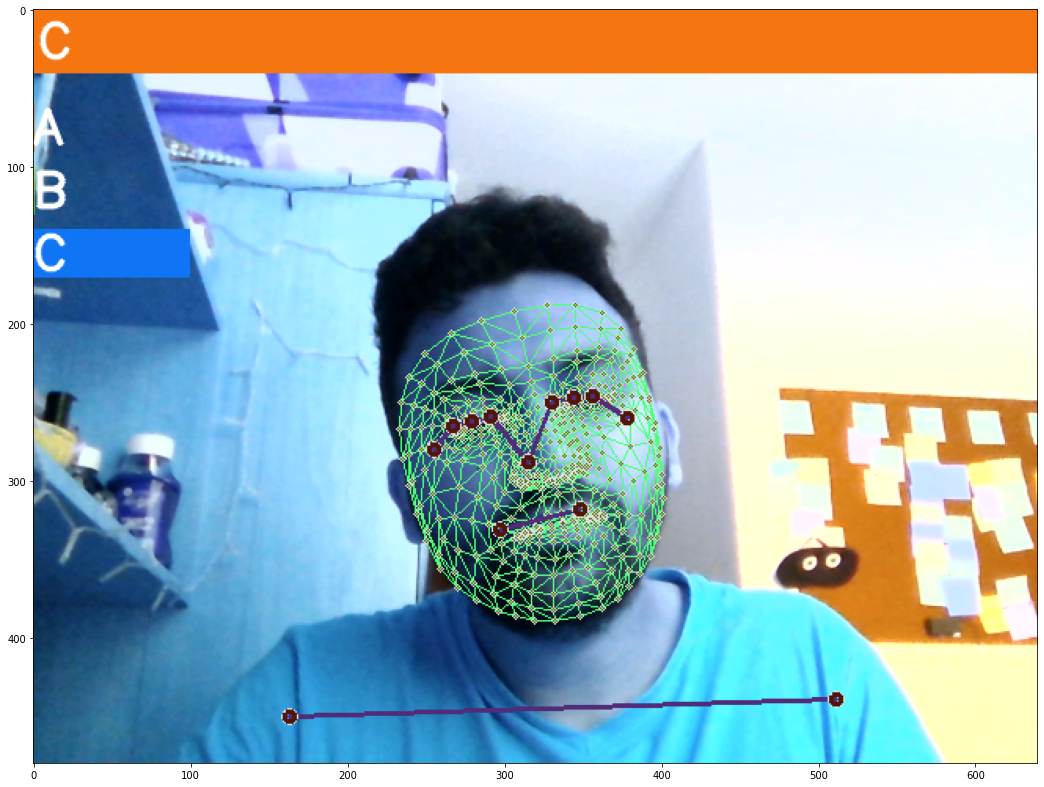

In [81]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))

In [82]:
sequence.reverse()

In [83]:
len(sequence)

30

In [84]:
sequence.append('def')

In [85]:
sequence.reverse()

In [86]:
sequence[-30:]

[array([ 0.75926572,  0.64685917, -0.77812785, ...,  0.30215642,
         0.30570048, -0.06648392]),
 array([ 0.76122725,  0.64686799, -0.8003065 , ...,  0.27648756,
         0.29787582, -0.0533629 ]),
 array([ 0.76091611,  0.64645875, -0.94365084, ...,  0.26024696,
         0.30040285, -0.04863742]),
 array([ 0.76066625,  0.64545238, -0.91739291, ...,  0.22861232,
         0.40770897, -0.03343351]),
 array([ 0.75871319,  0.64543474, -1.00912821, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.74727857,  0.6427145 , -1.12075937, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.73741454,  0.63142109, -1.08105314, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.70735109,  0.62747103, -1.13977683, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.67186314,  0.63144201, -1.11451983, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.65879178,  0.63664663, -1.40423393, ...,  0.        ,
         0.        ,  0.  

In [76]:
# 1. New detection variables
sequence = []
sentence = []
threshold = 0.8

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
#         sequence.insert(0,keypoints)
#         sequence = sequence[:30]
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            
            
        #3. Viz logic
            if res[np.argmax(res)] > threshold: 
                if len(sentence) > 0: 
                    if actions[np.argmax(res)] != sentence[-1]:
                        sentence.append(actions[np.argmax(res)])
                else:
                    sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

1/1 [==============================] - 0s 37ms/step
B
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 31ms/step
C
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 33ms/step
C
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 34ms/step
C
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 35ms/step
B
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 34ms/step
C
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 36ms/step
A
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 41ms/step
C
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 37ms/step
A
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1

1/1 [==============================] - 0s 45ms/step
A
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 36ms/step
A
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 45ms/step
A
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 47ms/step
A
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 35ms/step
A
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 29ms/step
A
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 53ms/step
A
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 36ms/step
A
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 33ms/step
A
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1

1/1 [==============================] - 0s 37ms/step
B
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 42ms/step
C
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 36ms/step
A
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 35ms/step
A
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 27ms/step
A
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 26ms/step
C
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 29ms/step
A
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 29ms/step
A
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 31ms/step
A
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1

1/1 [==============================] - 0s 36ms/step
A
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 31ms/step
A
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 30ms/step
A
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 32ms/step
A
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 38ms/step
A
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 38ms/step
A
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 32ms/step
A
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 35ms/step
A
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 36ms/step
A
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1

In [77]:
cap.release()
cv2.destroyAllWindows()

In [78]:
res[np.argmax(res)] > threshold

True

In [79]:
(num_sequences,30,1662)

NameError: name 'num_sequences' is not defined

In [80]:
model.predict(np.expand_dims(X_test[0], axis=0))

1/1 [==============================] - 0s 47ms/step


array([[0.5010371 , 0.21669495, 0.28226796]], dtype=float32)